In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../../dataset/processed/train_cleaned_v2.csv")
train.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,1.0,22.0,300.0,10.0,Moderate slope,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,mud,not applicable,Not attached,...,0.0,Non-residential,0.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
1,3.0,22.0,360.0,18.0,Flat,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
2,2.0,8.0,380.0,17.0,Flat,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,brick or stone,timber-planck,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,2.0,22.0,250.0,14.0,Flat,Clay mortar-Stone/Brick,Bamboo or Timber Light roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,0.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
4,2.0,7.0,312.0,13.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,available,5.0,2.0,2.0


In [3]:
X = train.drop(['damage_grade'], axis=1)
y = train['damage_grade']
y-= 1

In [109]:

from imblearn.over_sampling import SMOTE


In [4]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=69420, stratify=y)
te = TargetEncoder(smoothing=100)
X = te.fit_transform(X, y)
# sm = SMOTE()
# X_train = te.fit_transform(X_train, y_train)
# X_test = te.transform(X_test)

# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
# y_train_res = pd.Series(y_train_res)

# X_train.head()


In [111]:
y_train_res.value_counts()

2.0    12723
4.0    12723
0.0    12723
3.0    12723
1.0    12723
Name: damage_grade, dtype: int64

In [6]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    }

    model = XGBClassifier(**params, random_state=69420, n_thread=6)
    score = cross_val_score(model, X, y, cv=5, scoring='f1_macro').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=6, timeout=600)


[I 2023-04-11 18:55:20,009] A new study created in memory with name: no-name-898061b2-1392-4c70-a482-707de03d88e7
[I 2023-04-11 18:56:20,873] Trial 1 finished with value: 0.6537508559846452 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.41672784905910937, 'reg_alpha': 0.011700866525360083, 'reg_lambda': 0.29772163817153546}. Best is trial 1 with value: 0.6537508559846452.
[I 2023-04-11 18:57:25,927] Trial 0 finished with value: 0.6649010137099323 and parameters: {'n_estimators': 683, 'max_depth': 8, 'learning_rate': 0.44105495241694403, 'reg_alpha': 8.593372234746504, 'reg_lambda': 0.004265649459890694}. Best is trial 0 with value: 0.6649010137099323.
[I 2023-04-11 18:59:33,125] Trial 7 finished with value: 0.6517449243009281 and parameters: {'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.08160027523300067, 'reg_alpha': 1.641161451173073, 'reg_lambda': 0.07115007433839939}. Best is trial 0 with value: 0.6649010137099323.
[I 2023-04-11 19:00:31,151] Tr

In [137]:


xgb = XGBClassifier(max_depth=5)
xgb.fit(X_train_res, y_train_res)

y_pred = xgb.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.6606484088399759

Text(0.5, 0, 'Feature Importance Score')

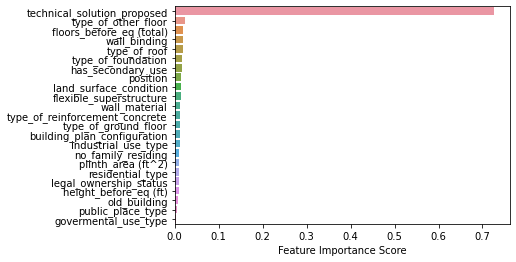

In [113]:
feat_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feat_imp, y=feat_imp.index)
plt.xlabel('Feature Importance Score')

In [138]:
test = pd.read_csv("../../dataset/processed/test_encoded_v3.csv")
test.head()

,id,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,...,has_secondary_use,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material
0,0,2.0,7,418.0,14,2,3.924681,3.747907,3.837207,3.899777,...,0.0,3.739428,3.692359,3.666844,1,3.635343,1,0,3.96323,3.966212
1,1,3.0,13,396.0,21,2,3.924681,3.810115,3.741800,3.899777,...,0.0,3.739428,3.692359,3.666844,1,3.635343,1,0,3.96323,3.966212
2,2,3.0,40,400.0,18,2,3.924681,3.747907,3.837207,3.899777,...,0.0,3.739428,3.692359,3.666844,1,3.635343,1,0,3.96323,3.966212
3,3,2.0,25,378.0,20,2,2.491733,3.810115,3.847860,3.899777,...,0.0,3.739428,3.692359,3.666844,1,3.635343,1,0,3.96323,3.966212
4,4,2.0,5,375.0,20,2,3.929950,3.743924,3.837207,3.899777,...,0.0,3.739428,3.692359,3.666844,1,3.635343,1,0,3.96323,3.966212


In [152]:
t = pd.read_csv("../../dataset/processed/train_encoded_v3_allTE.csv")

In [150]:
test.drop("id", axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
floors_before_eq (total),242082.0,2.087991,0.654766,1.000000,2.000000,2.000000,2.000000,9.000000
old_building,242082.0,24.239787,64.654998,0.000000,9.000000,16.000000,27.000000,999.000000
plinth_area (ft^2),242082.0,399.050615,184.206775,70.000000,280.000000,358.000000,470.000000,1000.000000
height_before_eq (ft),242082.0,16.047682,5.445992,6.000000,12.000000,16.000000,18.000000,99.000000
land_surface_condition,242082.0,1.796515,0.475794,0.000000,2.000000,2.000000,2.000000,2.000000
type_of_foundation,242082.0,3.643388,0.635133,1.571726,3.921709,3.921709,3.924681,3.929950
type_of_roof,242082.0,3.644852,0.482609,1.708440,3.743924,3.747907,3.806631,3.810115
type_of_ground_floor,242082.0,3.645973,0.554132,1.952571,3.837207,3.837207,3.837207,3.847860
type_of_other_floor,242082.0,3.641816,0.507212,1.580089,3.725698,3.899777,3.899777,3.899777
position,242082.0,3.645112,0.101021,3.040948,3.637114,3.637114,3.637114,3.777806


In [153]:
t.describe().T

,count,mean,std,min,25%,50%,75%,max
floors_before_eq (total),46801.0,2.092648,0.651499,1.000000,2.000000,2.000000,2.000000,7.000000
old_building,46801.0,24.545886,65.814197,0.000000,9.000000,16.000000,27.000000,999.000000
plinth_area (ft^2),46801.0,397.844768,183.198055,70.000000,280.000000,360.000000,468.000000,1000.000000
height_before_eq (ft),46801.0,16.089015,5.474914,6.000000,12.000000,16.000000,18.000000,99.000000
land_surface_condition,46801.0,1.795047,0.477621,0.000000,2.000000,2.000000,2.000000,2.000000
type_of_foundation,46801.0,3.644623,0.632413,1.571726,3.921709,3.921709,3.924681,3.929950
type_of_roof,46801.0,3.644623,0.483307,1.708440,3.743924,3.747907,3.806631,3.810115
type_of_ground_floor,46801.0,3.644703,0.556010,1.952571,3.837207,3.837207,3.837207,3.847860
type_of_other_floor,46801.0,3.644625,0.504446,1.580089,3.725698,3.899777,3.899777,3.899777
position,46801.0,3.644624,0.101851,3.040948,3.637114,3.637114,3.637114,3.777806


In [177]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_res, y_train_res, epochs=100, batch_size=32)

Epoch 1/100
1988/1988 [==============================] - 2s 910us/step - loss: 1.2646 - accuracy: 0.4551
Epoch 2/100
1988/1988 [==============================] - 2s 900us/step - loss: 0.8067 - accuracy: 0.6281
Epoch 3/100
1988/1988 [==============================] - 2s 904us/step - loss: 0.7569 - accuracy: 0.6494
Epoch 4/100
1988/1988 [==============================] - 2s 900us/step - loss: 0.7469 - accuracy: 0.6507
Epoch 5/100
1988/1988 [==============================] - 2s 894us/step - loss: 0.7392 - accuracy: 0.6535
Epoch 6/100
1988/1988 [==============================] - 2s 892us/step - loss: 0.7310 - accuracy: 0.6584
Epoch 7/100
1988/1988 [==============================] - 2s 893us/step - loss: 0.7248 - accuracy: 0.6594
Epoch 8/100
1988/1988 [==============================] - 2s 893us/step - loss: 0.7225 - accuracy: 0.6611
Epoch 9/100
1988/1988 [==============================] - 2s 910us/step - loss: 0.7177 - accuracy: 0.6641
Epoch 10/100
1988/1988 [==============================]

In [178]:
y_pred_tf = model.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

f1_score(y_test, y_pred_tf, average="macro")

366/366 [==============================] - 0s 683us/step


0.6625185493721691